# Курсовой проект "Оценка риска невыплаты кредита в срок"

**Подключение библиотек и скриптов**

In [273]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [274]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [275]:
import warnings
warnings.filterwarnings('ignore')

In [276]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [277]:
matplotlib.rcParams.update({'font.size': 14})

In [278]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [279]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [280]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [281]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [282]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [283]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/kurs_biblioteki_python2/train.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/kurs_biblioteki_python2/test.csv'

## Загрузка данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [284]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [285]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [286]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [287]:
train_df.shape


(7500, 17)

In [288]:
test_df.shape

(2500, 16)

## Приведение типов

In [289]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## EDA

###Удаление дубликатов

In [290]:
train_df.duplicated().value_counts()

False    7500
dtype: int64

In [291]:
test_df.duplicated().value_counts()

False    2500
dtype: int64

### Обработка выбросов и пропусков

**Annual Income**

In [292]:
train_df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

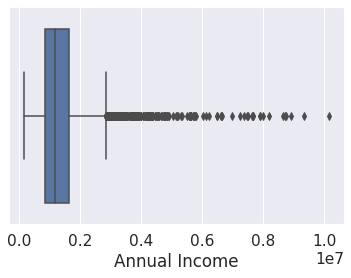

In [293]:
sns.boxplot(train_df['Annual Income'], whis=1.5)
plt.xlabel('Annual Income')
plt.show()

In [294]:
def condition(x):
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    iqr = q75 - q25
    return (x < (q25 - (1.5 * iqr))) | (x > (q75 + (1.5 * iqr))) | (x.isna())

In [295]:
train_df.loc[condition(train_df['Annual Income']), 'Annual Income'] = train_df['Annual Income'].median()

In [296]:
train_df['Annual Income'].describe()

count    7.500000e+03
mean     1.217461e+06
std      4.674006e+05
min      1.645970e+05
25%      9.311330e+05
50%      1.168386e+06
75%      1.404480e+06
max      2.833185e+06
Name: Annual Income, dtype: float64

**Years in current job**

In [297]:
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job'] = train_df['Years in current job'].mode()[0]

**Tax Liens**

In [298]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [299]:
train_df.loc[train_df['Tax Liens'].isna(), 'Tax Liens'] = train_df['Tax Liens'].median()
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

**Number of Open Accounts**

In [300]:
train_df['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

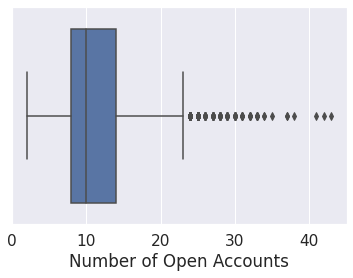

In [301]:
sns.boxplot(train_df['Number of Open Accounts'], whis=1.5)
plt.xlabel('Number of Open Accounts')
plt.show()

In [302]:
train_df.loc[condition(train_df['Number of Open Accounts']), 'Number of Open Accounts'] = train_df['Number of Open Accounts'].median()

In [303]:
train_df['Number of Open Accounts'].describe()

count    7500.000000
mean       10.741733
std         4.222331
min         2.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        23.000000
Name: Number of Open Accounts, dtype: float64

**Years of Credit History**

In [304]:
train_df['Years of Credit History'].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

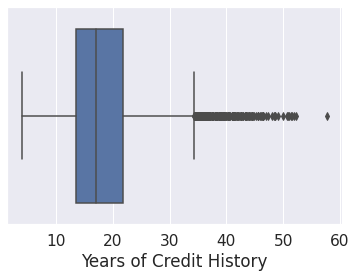

In [305]:
sns.boxplot(train_df['Years of Credit History'], whis=1.5)
plt.xlabel('Years of Credit History')
plt.show()

In [306]:
train_df.loc[condition(train_df['Years of Credit History']), 'Years of Credit History'] = train_df['Years of Credit History'].median()

In [307]:
train_df['Years of Credit History'].describe()

count    7500.000000
mean       17.637360
std         5.924193
min         4.000000
25%        13.500000
50%        17.000000
75%        21.000000
max        34.200000
Name: Years of Credit History, dtype: float64

**Maximum Open Credit**

In [308]:
train_df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

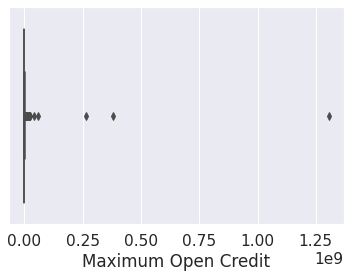

In [309]:
sns.boxplot(train_df['Maximum Open Credit'], whis=1.5)
plt.xlabel('Maximum Open Credit')
plt.show()

In [310]:
train_df.loc[condition(train_df['Maximum Open Credit']), 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

In [311]:
train_df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     5.205605e+05
std      3.222882e+05
min      0.000000e+00
25%      2.792295e+05
50%      4.781535e+05
75%      6.944795e+05
max      1.562550e+06
Name: Maximum Open Credit, dtype: float64

**Number of Credit Problems**

In [312]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [313]:
train_df.loc[train_df['Number of Credit Problems'].isna(), 'Number of Credit Problems'] = train_df['Number of Credit Problems'].median()
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

**Months since last delinquent**

In [314]:
train_df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

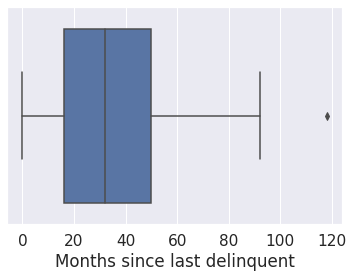

In [315]:
sns.boxplot(train_df['Months since last delinquent'], whis=1.5)
plt.xlabel('Months since last delinquent')
plt.show()

In [316]:
train_df.loc[condition(train_df['Months since last delinquent']), 'Months since last delinquent'] = train_df['Months since last delinquent'].median()

In [317]:
train_df['Months since last delinquent'].describe()

count    7500.00000
mean       33.21600
std        14.67133
min         0.00000
25%        32.00000
50%        32.00000
75%        32.00000
max        92.00000
Name: Months since last delinquent, dtype: float64

**Bankruptcies**

In [318]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [319]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = train_df['Bankruptcies'].median()
train_df['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

**Term**

In [320]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [321]:
binary_to_numbers = {'Short Term': 0, 'Long Term': 1}

train_df['Term'] = train_df['Term'].replace(binary_to_numbers)
train_df['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

**Current Loan Amount**

In [322]:
train_df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

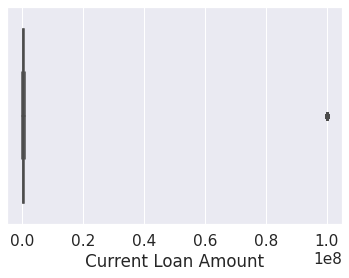

In [323]:
sns.boxplot(train_df['Current Loan Amount'], whis=1.5)
plt.xlabel('Current Loan Amount')
plt.show()

In [324]:
train_df.loc[(condition(train_df['Current Loan Amount'])) | (train_df['Current Loan Amount'] > 1e7), 
             'Current Loan Amount'] = train_df['Current Loan Amount'].median()

In [325]:
train_df['Current Loan Amount'].describe()

count      7500.000000
mean     309088.029067
std      171393.740131
min       11242.000000
25%      180169.000000
50%      309567.500000
75%      396929.500000
max      789030.000000
Name: Current Loan Amount, dtype: float64

**Current Credit Balance**

In [326]:
train_df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

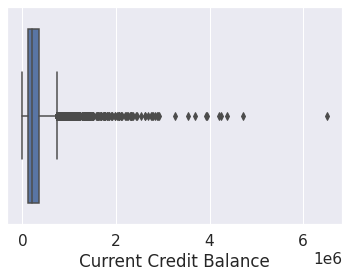

In [327]:
sns.boxplot(train_df['Current Credit Balance'], whis=1.5)
plt.xlabel('Current Credit Balance')
plt.show()

In [328]:
train_df.loc[condition(train_df['Current Credit Balance']), 'Current Credit Balance'] = train_df['Current Credit Balance'].median()

In [329]:
train_df['Current Credit Balance'].describe()

count      7500.000000
mean     232773.777867
std      159914.889827
min           0.000000
25%      114256.500000
50%      209313.500000
75%      313329.000000
max      729448.000000
Name: Current Credit Balance, dtype: float64

**Monthly Debt**

In [330]:
train_df['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

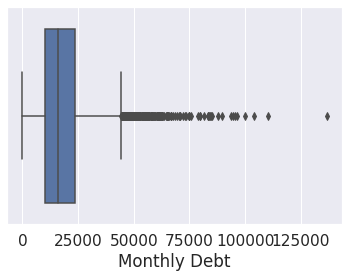

In [331]:
sns.boxplot(train_df['Monthly Debt'], whis=1.5)
plt.xlabel('Monthly Debt')
plt.show()

In [332]:
train_df.loc[condition(train_df['Monthly Debt']), 'Monthly Debt'] = train_df['Monthly Debt'].median()

In [333]:
train_df['Monthly Debt'].describe()

count     7500.000000
mean     16945.786067
std       9251.650675
min          0.000000
25%      10067.500000
50%      16075.750000
75%      22416.250000
max      44382.000000
Name: Monthly Debt, dtype: float64

**Credit Score**

In [334]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

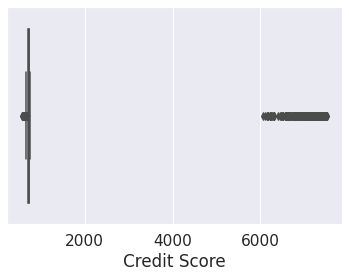

In [335]:
sns.boxplot(train_df['Credit Score'], whis=1.5)
plt.xlabel('Credit Score')
plt.show()

In [336]:
train_df.loc[(condition(train_df['Credit Score'])) | (train_df['Credit Score'] > 1000), 'Credit Score'] = train_df['Credit Score'].median()

In [337]:
train_df['Credit Score'].describe()

count    7500.000000
mean      726.586000
std        17.865239
min       663.000000
25%       722.000000
50%       731.000000
75%       738.000000
max       751.000000
Name: Credit Score, dtype: float64

In [338]:
len(train_df) - train_df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Анализ целевой переменной

In [339]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

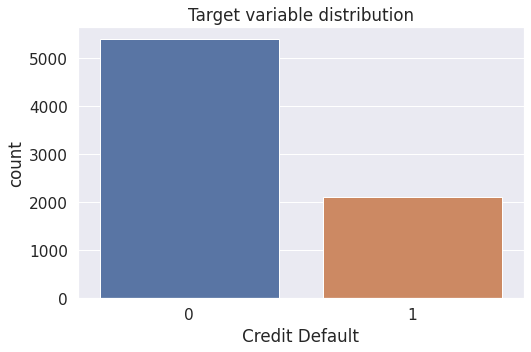

In [340]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Credit Default', data=train_df)
plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

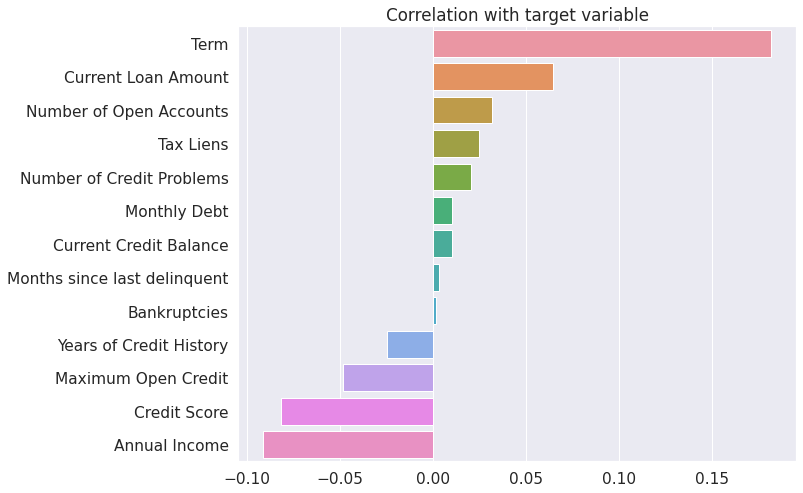

In [341]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

**Оценка признака 'Term' в разрезе целевой переменной**

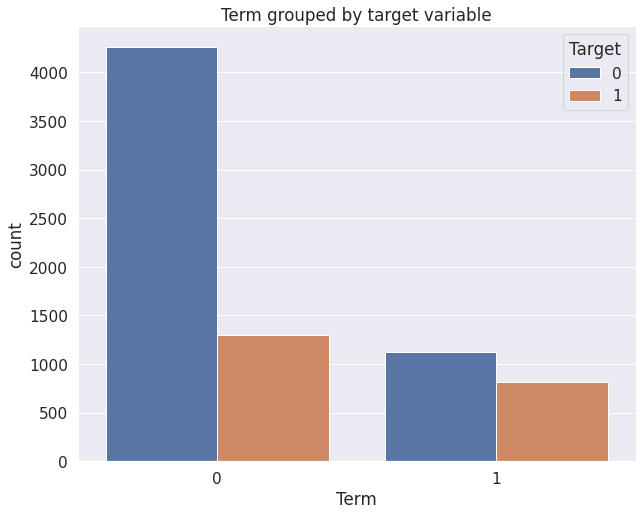

In [342]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Term', hue='Credit Default', data=train_df)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

Исходя из графика можно сделать вывод, что краткосрочные кредиты чаще погашают в срок и значит по краткосрочным кредитам реже бывают просрочки платежей по сравнению с кредитами на долгий срок.

**Оценка признака 'Annual Income' в разрезе целевой переменной**

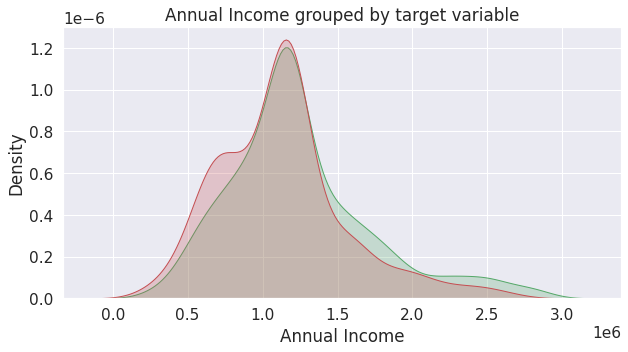

In [343]:
annual_income_with_target_s = train_df[['Annual Income', 'Credit Default']].sample(1000)
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s['Credit Default'] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s['Credit Default'] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака 'Annual Income' по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком 'Annual Income' и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что математические ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [344]:
shapiro(annual_income_s)

(0.9288223385810852, 2.2365679371662424e-21)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

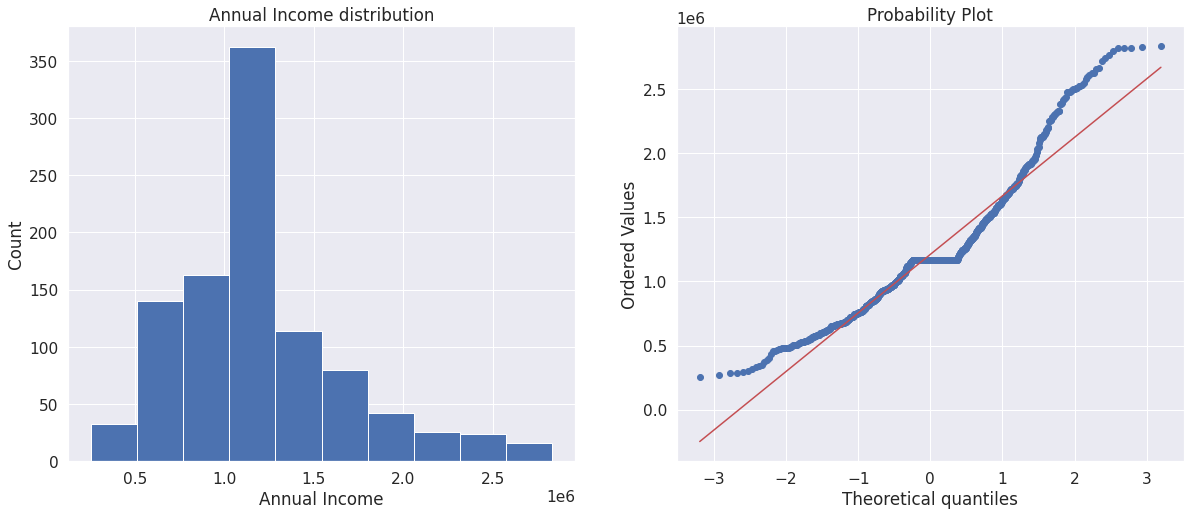

In [345]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income_s.hist()

plt.subplot(122)
probplot(annual_income_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности математических ожиданий признака 'Annual Income' в группах с погашенным вовремя кредитом и с просрочкой по кредиту, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность математических ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

In [346]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=85703.0, pvalue=0.0003358981457902766)

Согласно значению p-value, гипотеза о равности математических ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

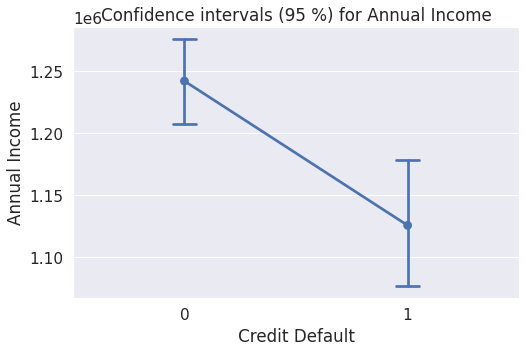

In [347]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Credit Default', y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные математические ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признаков

**Количественные признаки**

In [348]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.00000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.217461e+06,0.030133,10.741733,17.637360,5.205605e+05,0.170000,33.21600,0.116933,0.259200,309088.029067,232773.777867,16945.786067,726.586000,0.281733
std,4.674006e+05,0.271604,4.222331,5.924193,3.222882e+05,0.498598,14.67133,0.346904,0.438225,171393.740131,159914.889827,9251.650675,17.865239,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,11242.000000,0.000000,0.000000,663.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.00000,0.000000,0.000000,180169.000000,114256.500000,10067.500000,722.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781535e+05,0.000000,32.00000,0.000000,0.000000,309567.500000,209313.500000,16075.750000,731.000000,0.000000
75%,1.404480e+06,0.000000,13.000000,21.000000,6.944795e+05,0.000000,32.00000,0.000000,1.000000,396929.500000,313329.000000,22416.250000,738.000000,1.000000
max,2.833185e+06,7.000000,23.000000,34.200000,1.562550e+06,7.000000,92.00000,4.000000,1.000000,789030.000000,729448.000000,44382.000000,751.000000,1.000000


**Категориальные признаки**

In [349]:
for cat_colname in train_df.select_dtypes(include=object).columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Распределение количественных признаков**

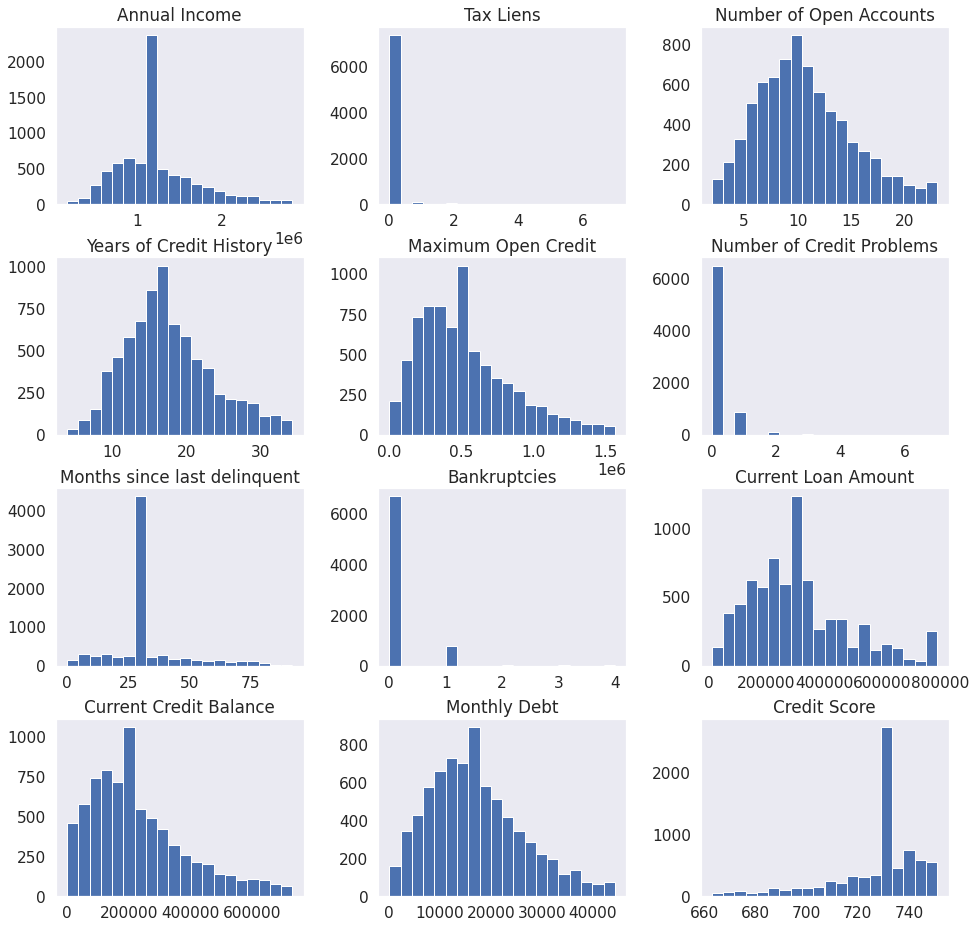

In [350]:
train_df.select_dtypes(include=float).hist(figsize=(16, 16), bins=20, grid=False);

**Корреляционная матрица**

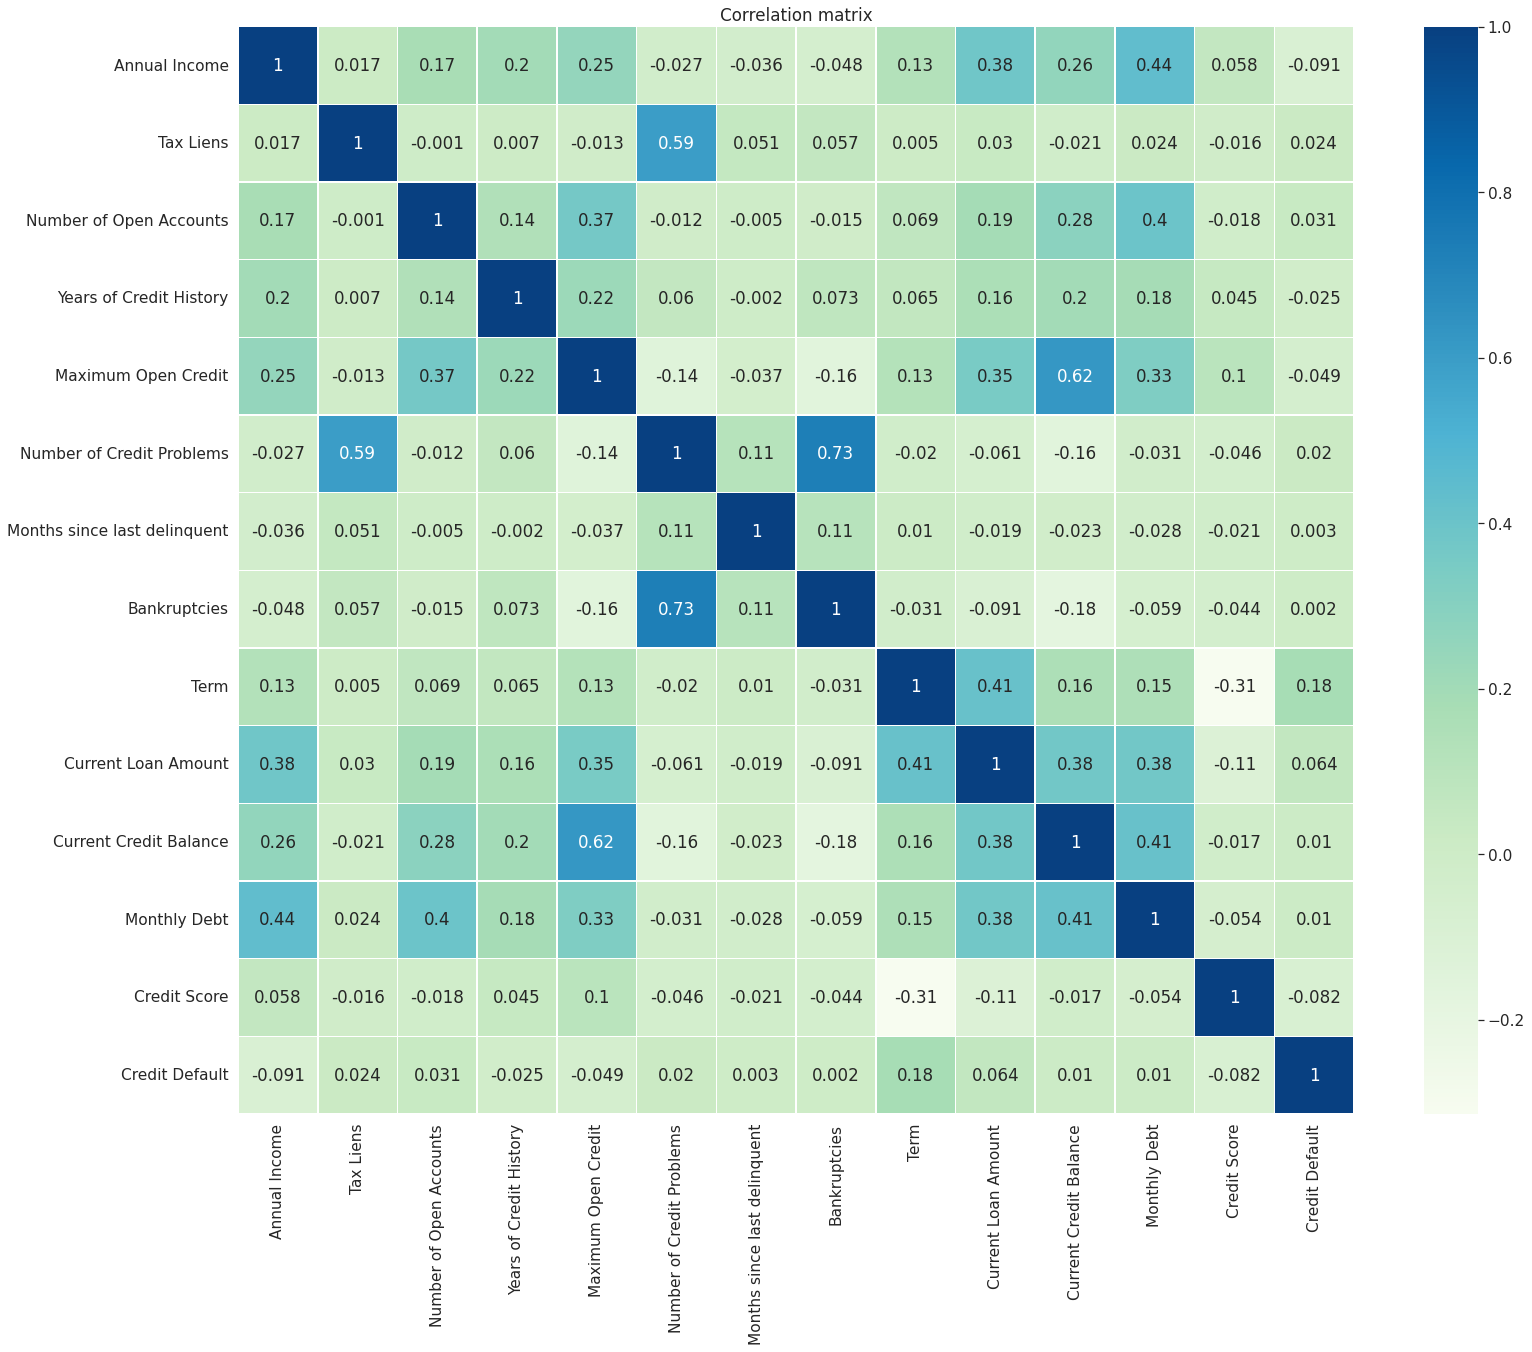

In [351]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(train_df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

### Построение новых признаков

**Years in current job Cat**

In [352]:
# def year_to_cat(X):

#     X['Years in current job Cat'] = 0

#     X.loc[X['Years in current job'].isin(['< 1 year', '1 year', '2 years', '3 years', '4 years']), 'Years in current job Cat'] = 1
#     X.loc[X['Years in current job'].isin(['5 years', '6 years', '7 years', '8 years', '9 years']), 'Years in current job Cat'] = 2
#     X.loc[X['Years in current job'] == '10+ years', 'Years in current job Cat'] = 3

#     return X

In [353]:
# train_df = year_to_cat(train_df)
# train_df.head()

### Отбор признаков

In [354]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [355]:
feature_names = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
                 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

target_name = 'Credit Default'

cat_feature_names = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

num_feature_names = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score']

### Приведение типов для модели CatBoost

In [356]:
for colname in cat_feature_names:
    train_df[colname] = pd.Categorical(train_df[colname])
    
train_df[cat_feature_names].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных<a class="anchor" id="normalization"></a>

In [357]:
scaler = StandardScaler()

train_df_norm = train_df.copy()
train_df_norm[num_feature_names] = scaler.fit_transform(train_df_norm[num_feature_names])

train_df = train_df_norm.copy()
train_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,-1.573431,10+ years,-0.110953,0.061171,1.462346,0.513238,1.664779,-0.082888,2.545732,debt consolidation,0,0.002830,-1.159368,-0.976300,1.254699,0
1,Own Home,-0.410753,10+ years,-0.110953,1.008578,-0.394571,2.051622,-0.340979,-0.082888,-0.337099,debt consolidation,1,-0.257436,1.014346,0.154276,0.582959,1
2,Home Mortgage,-0.997174,8 years,-0.110953,0.061171,-0.107593,2.053806,-0.340979,-0.082888,-0.337099,debt consolidation,0,0.002830,0.472878,-0.356153,0.862850,0
3,Own Home,-0.882370,6 years,-0.110953,-0.649385,0.820865,-1.157924,1.664779,-0.082888,2.545732,debt consolidation,0,-1.095166,-0.856255,-0.606179,-1.824111,0
4,Rent,-0.944000,8 years,-0.110953,0.534875,-0.681549,-0.418053,1.664779,-0.082888,-0.337099,debt consolidation,0,-1.069235,-0.872177,-1.055643,-0.424652,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,-1.744377,< 1 year,-0.110953,-1.833644,-1.542484,-1.280599,-0.340979,-0.082888,-0.337099,other,0,-1.048696,-0.996107,-1.626390,-1.656176,0
7496,Home Mortgage,0.677245,1 year,-0.110953,-0.175681,1.496108,0.514330,-0.340979,0.666923,-0.337099,debt consolidation,1,0.787479,1.398495,-0.449981,0.247088,1
7497,Rent,1.415260,6 years,-0.110953,0.298023,2.441447,-0.131573,-0.340979,-0.082888,-0.337099,buy a car,0,0.002830,1.532406,-0.482842,1.198720,0
7498,Home Mortgage,-0.105002,10+ years,-0.110953,2.429689,1.496108,1.926012,-0.340979,-0.082888,-0.337099,debt consolidation,0,1.786567,1.521475,2.180536,0.247088,0


In [358]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.modes=None
        self.binary_to_numbers=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()

        # Расчет моды
        self.modes = X.mode()

        # Переход из категорий Short Term/Long Term в 0/1
        self.binary_to_numbers = {'Short Term': 0, 'Long Term': 1}
    
    def transform(self, X):
        """Трансформация данных"""

        def condition(a):
            q25 = a.quantile(0.25)
            q75 = a.quantile(0.75)
            iqr = q75 - q25
            return (a < (q25 - (1.5 * iqr))) | (a > (q75 + (1.5 * iqr))) | (a.isna())

        def year_to_cat(X):

            X['Years in current job Cat'] = 0

            X.loc[X['Years in current job'].isin(['< 1 year', '1 year', '2 years', '3 years', '4 years']), 'Years in current job Cat'] = 1
            X.loc[X['Years in current job'].isin(['5 years', '6 years', '7 years', '8 years', '9 years']), 'Years in current job Cat'] = 2
            X.loc[X['Years in current job'] == '10+ years', 'Years in current job Cat'] = 3

            return X

        # Annual Income
        X.loc[condition(X['Annual Income']), 'Annual Income'] = self.medians['Annual Income']

        # Years in current job
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = self.modes['Years in current job'][0]

        # Tax Liens
        X.loc[X['Tax Liens'].isna(), 'Tax Liens'] = self.medians['Tax Liens']

        # Number of Open Accounts
        X.loc[condition(X['Number of Open Accounts']), 'Number of Open Accounts'] = self.medians['Number of Open Accounts']

        # Years of Credit History
        X.loc[condition(X['Years of Credit History']), 'Years of Credit History'] = self.medians['Years of Credit History']

        # Maximum Open Credit
        X.loc[condition(X['Maximum Open Credit']), 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Number of Credit Problems
        X.loc[train_df['Number of Credit Problems'].isna(), 'Number of Credit Problems'] = self.medians['Number of Credit Problems']
        
        # Months since last delinquent
        X.loc[condition(X['Months since last delinquent']), 'Months since last delinquent'] = self.medians['Months since last delinquent']
        
        # Bankruptcies
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.medians['Bankruptcies']

        # Term
        X['Term'] = X['Term'].map(self.binary_to_numbers)
        
        # Current Loan Amount
        X.loc[(condition(X['Current Loan Amount'])) | (X['Current Loan Amount'] > 1e7), 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Current Credit Balance
        X.loc[condition(X['Current Credit Balance']), 'Current Credit Balance'] = self.medians['Current Credit Balance']
        
        # Monthly Debt
        X.loc[condition(X['Monthly Debt']), 'Monthly Debt'] = self.medians['Monthly Debt']
        
        # Credit Score
        X.loc[(condition(X['Credit Score'])) | (X['Credit Score'] > 1000), 'Credit Score'] = self.medians['Credit Score']

        feature_names = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
                 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
                 
        target_name = 'Credit Default'
        
        cat_feature_names = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
        
        num_feature_names = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score']

        # Приведение типов для модели Catboost
        for colname in cat_feature_names:
            X[colname] = pd.Categorical(X[colname])

        # Нормализация данных
        scaler = StandardScaler()
        X_norm = X.copy()
        X_norm[num_feature_names] = scaler.fit_transform(X_norm[num_feature_names])
        X = X_norm.copy()
        
        return X

## Разбиение на train и test

In [359]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [360]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [361]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [362]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5025, 16), (2475, 16), (2500, 16))

In [363]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [364]:
# Балансировка
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3611
1    2828
Name: Credit Default, dtype: int64

In [365]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

## Построение и оценка базовых моделей

**Логистическая регрессия**

In [366]:
model_lr = LogisticRegression()
model_lr.fit(X_train[num_feature_names], y_train)

y_train_pred = model_lr.predict(X_train[num_feature_names])
y_test_pred = model_lr.predict(X_valid[num_feature_names])

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.60      0.78      0.68      3611
           1       0.55      0.35      0.43      2828

    accuracy                           0.59      6439
   macro avg       0.58      0.56      0.55      6439
weighted avg       0.58      0.59      0.57      6439

TEST

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1776
           1       0.37      0.34      0.35       699

    accuracy                           0.65      2475
   macro avg       0.56      0.56      0.56      2475
weighted avg       0.64      0.65      0.64      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1368  408
1                461  238


**k ближайших соседей**

In [367]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train[num_feature_names], y_train)

y_train_pred = model_knn.predict(X_train[num_feature_names])
y_test_pred = model_knn.predict(X_valid[num_feature_names])

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      3611
           1       0.72      0.67      0.69      2828

    accuracy                           0.74      6439
   macro avg       0.74      0.73      0.73      6439
weighted avg       0.74      0.74      0.74      6439

TEST

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1776
           1       0.35      0.40      0.37       699

    accuracy                           0.62      2475
   macro avg       0.55      0.55      0.55      2475
weighted avg       0.64      0.62      0.63      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1257  519
1                418  281


**Бустинговые алгоритмы**

*XGBoost*

In [368]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train[num_feature_names], y_train)

y_train_pred = model_xgb.predict(X_train[num_feature_names])
y_test_pred = model_xgb.predict(X_valid[num_feature_names])

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      3611
           1       0.73      0.64      0.68      2828

    accuracy                           0.74      6439
   macro avg       0.74      0.73      0.73      6439
weighted avg       0.74      0.74      0.74      6439

TEST

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1776
           1       0.45      0.54      0.49       699

    accuracy                           0.69      2475
   macro avg       0.63      0.64      0.63      2475
weighted avg       0.70      0.69      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1320  456
1                322  377


*LightGBM*

In [369]:
model_lgbm = lgbm.LGBMClassifier(random_state=21, categorical_feature=cat_feature_names)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3611
           1       0.92      0.93      0.93      2828

    accuracy                           0.94      6439
   macro avg       0.94      0.94      0.94      6439
weighted avg       0.94      0.94      0.94      6439

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1776
           1       0.47      0.49      0.48       699

    accuracy                           0.70      2475
   macro avg       0.63      0.64      0.64      2475
weighted avg       0.70      0.70      0.70      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1399  377
1                359  340


*CatBoost*

In [370]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=cat_feature_names)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3611
           1       0.88      0.85      0.87      2828

    accuracy                           0.88      6439
   macro avg       0.88      0.88      0.88      6439
weighted avg       0.88      0.88      0.88      6439

TEST

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1776
           1       0.48      0.51      0.50       699

    accuracy                           0.71      2475
   macro avg       0.64      0.65      0.64      2475
weighted avg       0.71      0.71      0.71      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1391  385
1                341  358


### Выбор лучшей модели и подбор гиперпараметров

In [371]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [372]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[4, 6, 8]}

In [373]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [374]:
# Подбор RandomizedSearch
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X[num_feature_names], y)

CPU times: user 3.62 s, sys: 396 ms, total: 4.01 s
Wall time: 2min 38s


In [375]:
rs.best_params_

{'max_depth': 4, 'n_estimators': 500}

In [376]:
rs.best_score_

0.533870220752357

In [377]:
# Подбор GridSearch
%%time

gs = GridSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
gs.fit(X[num_feature_names], y)

CPU times: user 4.5 s, sys: 483 ms, total: 4.99 s
Wall time: 4min 41s


In [378]:
gs.best_params_

{'max_depth': 4, 'n_estimators': 500}

In [379]:
gs.best_score_

0.533870220752357

### Обучение и оценка финальной модели

In [380]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=4, silent=True, 
                                      random_state=21, cat_features=cat_feature_names)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      3611
           1       0.79      0.72      0.75      2828

    accuracy                           0.79      6439
   macro avg       0.79      0.78      0.79      6439
weighted avg       0.79      0.79      0.79      6439

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1776
           1       0.47      0.55      0.51       699

    accuracy                           0.70      2475
   macro avg       0.64      0.65      0.65      2475
weighted avg       0.71      0.70      0.71      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1347  429
1                316  383
CPU times: user 6.33 s, sys: 588 ms, total: 6.92 s
Wall time: 4.08 s


### Снижение степени переобучения

In [381]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=4, l2_leaf_reg=1, silent=True, 
                                      random_state=21, cat_features=cat_feature_names)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_valid)
y_test_pred_probs = final_model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      3611
           1       0.76      0.68      0.72      2828

    accuracy                           0.77      6439
   macro avg       0.77      0.76      0.76      6439
weighted avg       0.77      0.77      0.76      6439

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1776
           1       0.47      0.55      0.51       699

    accuracy                           0.70      2475
   macro avg       0.64      0.66      0.65      2475
weighted avg       0.72      0.70      0.71      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1347  429
1                312  387


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [382]:
final_model2 = catb.CatBoostClassifier(n_estimators=500, max_depth=4,
                                      class_weights=[1, 3.5], silent=True, 
                                      random_state=21)

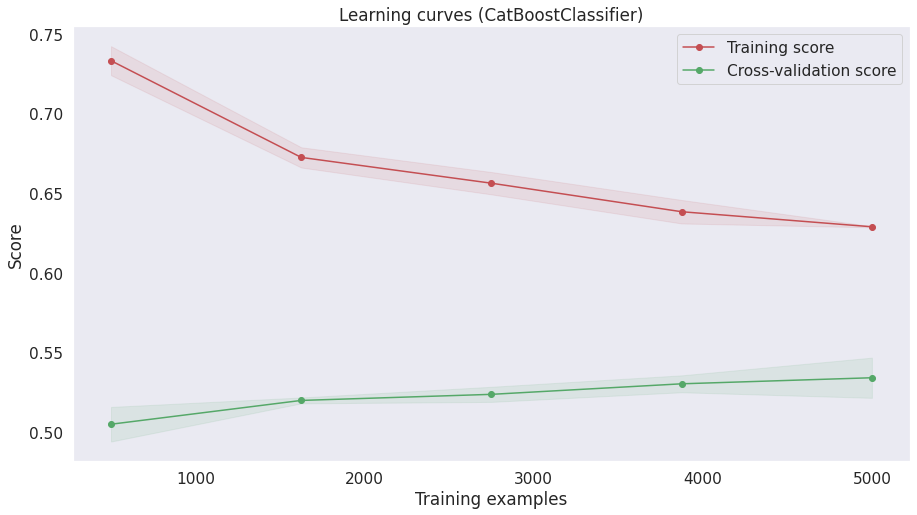

In [383]:
show_learning_curve_plot(final_model2, X[num_feature_names], y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

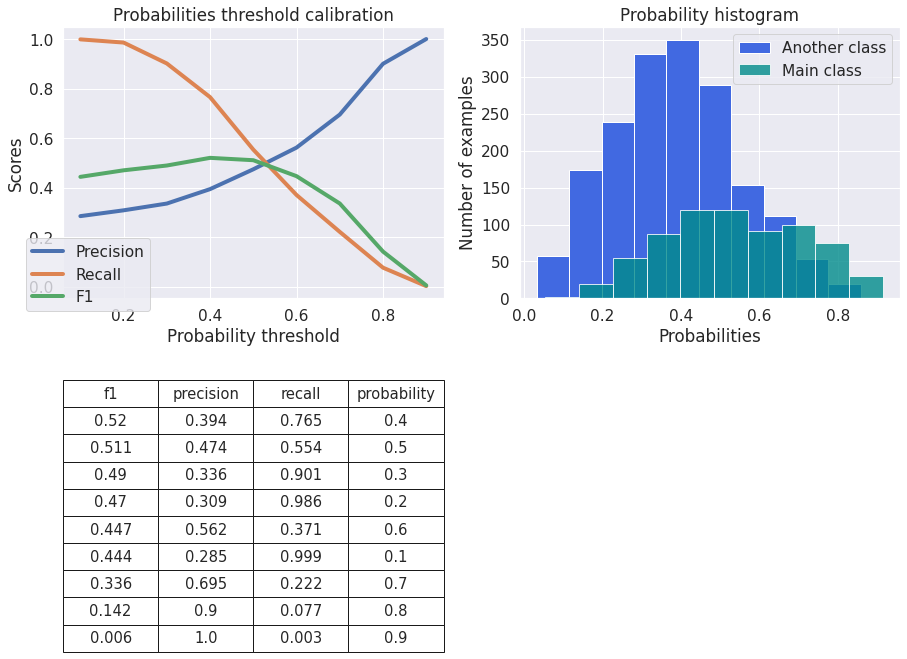

In [384]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_valid)

### Важность признаков<a class="anchor" id="feature_importances"></a>

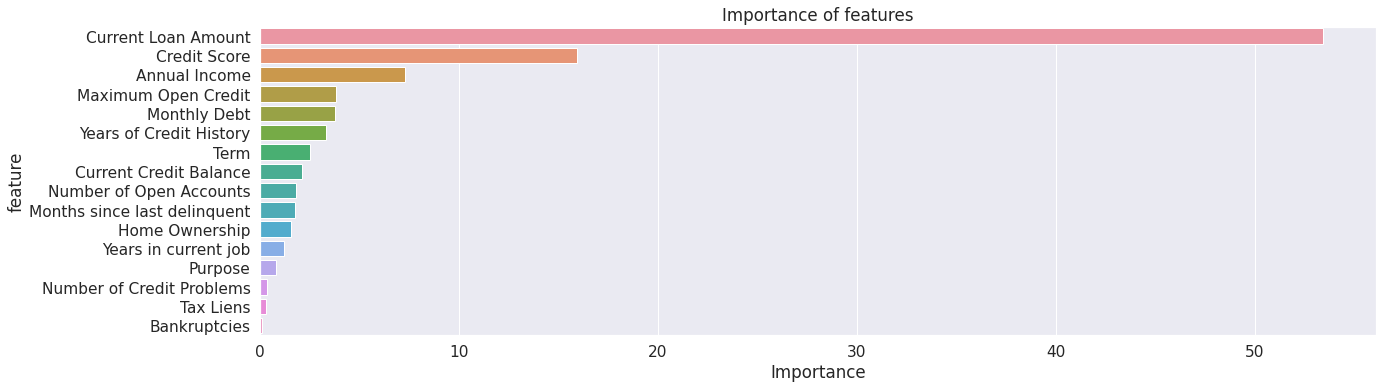

In [385]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=12)

In [386]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History',
 'Term',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Home Ownership',
 'Years in current job']

## Финальная модель<a class="anchor" id="final_model"></a>

In [387]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=4, l2_leaf_reg=1, silent=True, 
                                      random_state=21, cat_features=['Home Ownership', 'Term', 'Years in current job'])
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_valid[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3611
           1       0.77      0.71      0.74      2828

    accuracy                           0.78      6439
   macro avg       0.78      0.77      0.77      6439
weighted avg       0.78      0.78      0.78      6439

TEST

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1776
           1       0.47      0.59      0.52       699

    accuracy                           0.69      2475
   macro avg       0.64      0.66      0.65      2475
weighted avg       0.72      0.69      0.70      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1304  472
1                286  413


## Прогнозирование на тестовом датасете

In [388]:
test_df.shape

(2500, 16)

In [389]:
predictions = final_model.predict(test_df[important_features_top])
predictions

array([1, 0, 1, ..., 0, 0, 1])

In [390]:
test_df['Credit Default'] = predictions
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Rent,-0.075484,4 years,-0.091141,-0.436665,-0.840580,-0.922634,-0.289398,2.480359,-0.299225,debt consolidation,0,-0.877076,-0.785244,-1.100201,0.271355,1
1,Rent,-2.167869,1 year,-0.091141,-1.141417,2.450725,-1.421335,-0.289398,-1.675514,-0.299225,educational expenses,0,-1.368056,-1.146150,-1.578360,-1.497006,0
2,Home Mortgage,-0.133319,3 years,-0.091141,-0.201747,-0.645057,-0.972098,-0.289398,-0.066789,-0.299225,debt consolidation,0,-0.657123,-0.540593,0.167372,0.271355,1
3,Home Mortgage,0.016444,10+ years,-0.091141,1.207758,-0.107368,-0.211447,-0.289398,2.480359,-0.299225,debt consolidation,0,-0.556771,-0.138454,1.106670,0.713445,0
4,Home Mortgage,2.492810,6 years,-0.091141,0.033170,0.968008,2.058009,-0.289398,-0.066789,-0.299225,debt consolidation,1,2.711214,1.140695,2.707199,-1.110177,0


In [391]:
submit = test_df['Credit Default']
submit.head(10)

0    1
1    0
2    1
3    0
4    0
5    0
6    0
7    0
8    1
9    0
Name: Credit Default, dtype: int64

In [392]:
submit.to_csv('/content/drive/My Drive/Colab Notebooks/kurs_biblioteki_python2/KhalimovaAlina_prediction.csv', index=False, encoding='utf-8')

In [393]:
submit2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kurs_biblioteki_python2/KhalimovaAlina_prediction.csv')
submit2.head()

,Credit Default
0,1
1,0
2,1
3,0
4,0


In [394]:
submit2.value_counts()

Credit Default
0                 1680
1                  820
dtype: int64